# Projet 7 : Implémentez un modèle de scoring

## Problématique

L'objectif est de développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, ...).

L'objectif de ce notebook :

* Choisir les features pertinentes pour la modélisation en se basant sur le kernel EDA précédent de l'analyse exploratoire.
* Choisir les variables numériques suivants les critères suivantes:

- choisir features corrélées avec la variable Target.
- Eviter les feautures très corrélées entre elles.
- choisir les features avec un seuil des variables manquantes inférieur à 60 %.
- Créer des nouvelles features pertinentes.

* Choisir les variables catégoriques suivants les critères suivantes:

- choisir les features avec un seuil des variables manquantes inférieur à 60 %.
- choisir les features avec le minimum de modes sinon les mapper .
- choisir des features qui ont des relations avec la target en se basant sur l'analyse exploratoire.


In [4]:
#from google.colab import files, output, drive
#drive.mount('/gdrive')
#%cd /gdrive

## Importation des modules

In [5]:
import pandas as pd 
import numpy as np
import gc
%matplotlib inline 
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
import os
os.getcwd()

'/home/ebakangu/Projet7/Notebooks'

In [7]:
# Reduce Memory Usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Grab Column Names
def grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False):
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "datetime64[ns]"]

    #cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    cat_cols = dataframe.select_dtypes(["object", "category"]).columns.tolist()
    
    
    
    num_but_cat = [col for col in dataframe.select_dtypes(["float", "integer"]).columns if dataframe[col].nunique() < cat_th]

    cat_but_car = [col for col in dataframe.select_dtypes(["object", "category"]).columns if dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = dataframe.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'date_cols: {len(date_cols)}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    if show_date == True:
        return date_cols, cat_cols, cat_but_car, num_cols, num_but_cat
    else:
        return cat_cols, cat_but_car, num_cols, num_but_cat

# Categorical Variables & Target
def cat_analyzer(dataframe, variable, target = None):
    print(variable)
    if target == None:
        print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe)}), end="\n\n\n")
    else:
        temp = dataframe[dataframe[target].isnull() == False]
        print(pd.DataFrame({
            "COUNT":dataframe[variable].value_counts(),
            "RATIO":dataframe[variable].value_counts() / len(dataframe),
            "TARGET_COUNT":dataframe.groupby(variable)[target].count(),
            "TARGET_MEAN":temp.groupby(variable)[target].mean(),
            "TARGET_MEDIAN":temp.groupby(variable)[target].median(),
            "TARGET_STD":temp.groupby(variable)[target].std()}), end="\n\n\n")

# Numerical Variables
def corr_plot(data, remove=["Id"], corr_coef = "pearson", figsize=(20, 20)):
    if len(remove) > 0:
        num_cols2 = [x for x in data.columns if (x not in remove)]

    sns.set(font_scale=1.1)
    c = data[num_cols2].corr(method = corr_coef)
    mask = np.triu(c.corr(method = corr_coef))
    plt.figure(figsize=figsize)
    sns.heatmap(c,
                annot=True,
                fmt='.1f',
                cmap='coolwarm',
                square=True,
                mask=mask,
                linewidths=1,
                cbar=False)
    plt.show()

# Plot numerical variables
def num_plot(data, num_cols, remove=["Id"], hist_bins=10, figsize=(20, 4)):

    if len(remove) > 0:
        num_cols2 = [x for x in num_cols if (x not in remove)]

    for i in num_cols2:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        data.hist(str(i), bins=hist_bins, ax=axes[0])
        data.boxplot(str(i), ax=axes[1], vert=False);
        try:
            sns.kdeplot(np.array(data[str(i)]))
        except:
            ValueError

        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(i + " | Histogram")
        axes[1].set_title(i + " | Boxplot")
        axes[2].set_title(i + " | Density")
        plt.show()

# Get high correlated variables
def high_correlation(data, remove=['SK_ID_CURR', 'SK_ID_BUREAU'], corr_coef="pearson", corr_value = 0.7):
    if len(remove) > 0:
        cols = [x for x in data.columns if (x not in remove)]
        c = data[cols].corr(method=corr_coef)
    else:
        c = data.corr(method=corr_coef)

    for i in c.columns:
        cr = c.loc[i].loc[(c.loc[i] >= corr_value) | (c.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")

# Missing Value
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")
    
    
# Quantile functions for aggregations
def quantile_funcs(percentiles = [0.75, 0.9, 0.99]):
    return [(p, lambda x: x.quantile(p)) for p in percentiles]

# Rare Encoder
def rare_encoder(data, col, rare_perc):
    temp = data[col].value_counts() / len(data) < rare_perc
    data[col] = np.where(~data[col].isin(temp[temp < rare_perc].index), "Rare", data[col])

##  Importation de données

In [8]:
path_data = '~/Data/'

In [9]:
application_train = pd.read_csv(path_data+"/application_train.csv")
application_test = pd.read_csv(path_data+"/application_test.csv")
bureau = pd.read_csv(path_data+"/bureau.csv")

In [10]:
application_train = reduce_mem_usage(application_train)
application_test = reduce_mem_usage(application_test)
bureau = reduce_mem_usage(bureau)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%


In [11]:
bureau_balance = pd.read_csv(path_data+"/bureau_balance.csv")
credit_card_balance = pd.read_csv(path_data+"/credit_card_balance.csv")

In [13]:
bureau_balance = reduce_mem_usage(bureau_balance)
credit_card_balance = reduce_mem_usage(credit_card_balance)

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%


In [14]:
installments_payments = pd.read_csv(path_data+"/installments_payments.csv")
previous_application = pd.read_csv(path_data+"/previous_application.csv")
POS_CASH_balance = pd.read_csv(path_data+"/POS_CASH_balance.csv")

In [15]:
installments_payments = reduce_mem_usage(installments_payments)
previous_application = reduce_mem_usage(previous_application)
POS_CASH_balance = reduce_mem_usage(POS_CASH_balance)

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%


In [17]:
print("Dimension")
print('........................................................................')
print("application_train -  rows:",application_train.shape[0]," columns:", application_train.shape[1])
print("application_test -  rows:",application_test.shape[0]," columns:", application_test.shape[1])
print("bureau -  rows:",bureau.shape[0]," columns:", bureau.shape[1])
print("bureau_balance -  rows:",bureau_balance.shape[0]," columns:", bureau_balance.shape[1])
print("credit_card_balance -  rows:",credit_card_balance.shape[0]," columns:", credit_card_balance.shape[1])
print("installments_payments -  rows:",installments_payments.shape[0]," columns:", installments_payments.shape[1])
print("previous_application -  rows:",previous_application.shape[0]," columns:", previous_application.shape[1])
print("POS_CASH_balance -  rows:",POS_CASH_balance.shape[0]," columns:", POS_CASH_balance.shape[1])

Dimension
........................................................................
application_train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121
bureau -  rows: 1716428  columns: 17
bureau_balance -  rows: 27299925  columns: 3
credit_card_balance -  rows: 3840312  columns: 23
installments_payments -  rows: 13605401  columns: 8
previous_application -  rows: 1670214  columns: 37
POS_CASH_balance -  rows: 10001358  columns: 8


In [18]:
gc.enable()
del application_train,bureau_balance,installments_payments
gc.collect()

479

In [19]:
gc.enable()

### Application train 

In [20]:
application_train = pd.read_csv(path_data+"/application_train.csv")
application_train = reduce_mem_usage(application_train)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%


In [21]:
building_normal_info_list = ['APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE',
'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE',
'ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE',
'LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI',
'BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI',
'ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI',
'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE',
'HOUSETYPE_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE' ]

In [22]:
application_train.drop(building_normal_info_list,axis=1,inplace=True)

In [23]:
client_doc = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6',
'FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12',
'FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18',
'FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']

In [24]:
application_train.drop(client_doc,axis=1,inplace=True)

In [25]:
AMT_REQ_CREDIT_BUREAU_list = ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT']

In [26]:
application_train.drop(AMT_REQ_CREDIT_BUREAU_list,axis=1,inplace=True)

In [27]:
social_surroundings_list = ['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE',
                            'DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE']

In [28]:
application_train.drop(social_surroundings_list,axis=1,inplace=True)

In [29]:
application_train.shape

(307511, 48)

In [30]:
external_score_list = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'] #=> !! data leakage !!! 

In [31]:
application_train.drop(external_score_list,axis=1,inplace=True)

In [32]:
application_train.shape

(307511, 45)

In [33]:
Flag_list = ['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
'REG_CITY_NOT_LIVE_CITY','LIVE_CITY_NOT_WORK_CITY']

In [34]:
application_train.drop(Flag_list,axis=1,inplace=True)

In [35]:
flag_phone_mail_list = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE',
'FLAG_PHONE','FLAG_EMAIL']

In [36]:
application_train.drop(flag_phone_mail_list,axis=1,inplace=True)

In [37]:
application_train.shape

(307511, 34)

In [38]:
AMT_list = ['AMT_ANNUITY','AMT_GOODS_PRICE']

In [39]:
application_train.drop(AMT_list,axis=1,inplace=True)

In [40]:
days_list = ['DAYS_REGISTRATION','DAYS_ID_PUBLISH' ]

In [41]:
application_train.drop(days_list,axis=1,inplace=True)

In [42]:
application_train.shape

(307511, 30)

In [43]:
#Family status remapped
dic = {'Single / not married':'not_married', 'Married':'married', 'Civil marriage':'married', 'Widow':'other',
       'Separated':'other', 'Unknown':'other'}
application_train=application_train.replace({"NAME_FAMILY_STATUS": dic})

In [44]:
application_train['NAME_FAMILY_STATUS'].unique()

['not_married', 'married', 'other']
Categories (3, object): ['married', 'not_married', 'other']

In [45]:
# NAME_INCOME_TYPE remapped
dic = {'Working':'working', 'State servant':'working', 'Commercial associate':'working', 'Pensioner':'working',
       'Unemployed':'not_working', 'Student':'not_working', 'Businessman':'working', 'Maternity leave':'not_working'}
application_train=application_train.replace({"NAME_INCOME_TYPE": dic})

In [46]:
application_train['NAME_INCOME_TYPE'].unique()

['working', 'not_working']
Categories (2, object): ['not_working', 'working']

In [47]:
# OCCUPATION_TYPE remapped
dic = {'Laborers':'other', 'Core staff':'other', 'Accountants':'other', 'Managers':'other',
       'Drivers':'other', 'Sales staff':'other', 'Cleaning staff':'other', 'Cooking staff':'other',
       'Private service staff':'other', 'Medicine staff':'other', 'Security staff':'other',
       'High skill tech staff':'other', 'Waiters/barmen staff':'other',
       'Low-skill Laborers':'Low-skill Laborers', 'Realty agents':'other', 'Secretaries':'other', 'IT staff':'other',
       'HR staff':'other'}
application_train=application_train.replace({"OCCUPATION_TYPE": dic})

In [48]:
application_train['OCCUPATION_TYPE'].unique()

['other', NaN, 'Low-skill Laborers']
Categories (2, object): ['other', 'Low-skill Laborers']

In [49]:
# NAME_EDUCATION_TYPE remapped
dic = {'Secondary / secondary special':'low_educ', 'Higher education':'high_educ',
       'Incomplete higher':'low_educ', 'Lower secondary':'low_educ', 'Academic degree':'high_educ'}
application_train=application_train.replace({"NAME_EDUCATION_TYPE": dic})

In [50]:
application_train['NAME_EDUCATION_TYPE'].unique()

['low_educ', 'high_educ']
Categories (2, object): ['high_educ', 'low_educ']

In [51]:
#drop not important categ
drop_categories_list = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','ORGANIZATION_TYPE','NAME_HOUSING_TYPE']

In [52]:
application_train.drop(drop_categories_list,axis=1,inplace=True)

In [53]:
application_train.shape

(307511, 26)

In [54]:
gc.collect()

473

In [55]:
df_final = application_train

In [56]:
gc.enable()
del application_train
gc.collect()

0

In [57]:
df_final.shape

(307511, 26)

## bureau_balance

In [65]:
bureau_balance = pd.read_csv(path_data+"/bureau_balance.csv")
#bureau_balance = reduce_mem_usage(bureau_balance)

In [66]:
bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [67]:
 df_inter = bureau_balance[bureau_balance['STATUS']!='C']

In [68]:
 df_inter = df_inter[df_inter['STATUS']!='X']

In [69]:
df_inter['STATUS']=df_inter['STATUS'].astype(int)

In [70]:
df_inter['STATUS']=df_inter['STATUS'].astype(int)

In [71]:
df_inter = df_inter[df_inter['MONTHS_BALANCE']>-25]

In [72]:
df_grouped = df_inter.groupby(['SK_ID_BUREAU'])['STATUS'].agg(lambda x:x.value_counts().index[0])

In [73]:
bureau_balanced_grouped = pd.DataFrame({'SK_ID_BUREAU':df_grouped.index,'status_most_freq':df_grouped.values})

In [74]:
bureau_balanced_grouped

,SK_ID_BUREAU,status_most_freq
0,5001711,0
1,5001712,0
2,5001717,0
3,5001718,0
4,5001720,0
...,...,...
394422,6842877,0
394423,6842878,0
394424,6842881,0
394425,6842882,0


In [75]:
gc.enable()
del df_inter,bureau_balance,df_grouped
gc.collect()

3962

##  Bureau

In [76]:
bureau = pd.read_csv(path_data+"/bureau.csv")
bureau = reduce_mem_usage(bureau)

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%


In [77]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,"91,323.00",0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",NaN,NaN,0,"225,000.00","171,342.00",NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,"464,323.50",NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,"90,000.00",NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,"1,197.00",NaN,"77,674.50",0,"2,700,000.00",NaN,NaN,0.00,Consumer credit,-21,NaN


In [78]:
bureau.shape

(1716428, 17)

In [79]:
bureau_list = ['CREDIT_CURRENCY','CREDIT_DAY_OVERDUE',
'DAYS_CREDIT_ENDDATE','DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG','AMT_CREDIT_SUM_DEBT',
'AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE','DAYS_CREDIT_UPDATE','AMT_ANNUITY','CREDIT_TYPE']

In [80]:
bureau.drop(bureau_list,axis=1,inplace=True)

In [81]:
bureau = bureau.merge(bureau_balanced_grouped, on = 'SK_ID_BUREAU', how = 'left')

In [82]:
df_grouped = bureau.groupby(['SK_ID_CURR']).agg({'CREDIT_ACTIVE': lambda x:x.value_counts().index[0], 'DAYS_CREDIT': 'mean','AMT_CREDIT_SUM':'mean'})

In [95]:
df_grouped

NameError: name 'df_grouped' is not defined

In [84]:
bureau_grouped = df_grouped

In [85]:
bureau_grouped.reset_index(inplace=True)

In [86]:
bureau_grouped

,SK_ID_CURR,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM
0,100001,Closed,-735.00,"207,623.58"
1,100002,Closed,-874.00,"108,131.95"
2,100003,Closed,"-1,400.75","254,350.12"
3,100004,Closed,-867.00,"94,518.90"
4,100005,Active,-190.67,"219,042.00"
...,...,...,...,...
305806,456249,Closed,"-1,667.08","284,142.97"
305807,456250,Active,-862.00,"1,028,819.81"
305808,456253,Active,-867.50,"990,000.00"
305809,456254,Closed,"-1,104.00","45,000.00"


In [87]:
gc.enable()
del bureau,bureau_balanced_grouped,df_grouped
gc.collect()


0

## credit_card_balance

In [88]:
credit_card_balance = pd.read_csv(path_data+"/credit_card_balance.csv")
credit_card_balance = reduce_mem_usage(credit_card_balance)

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%


In [89]:
credit_card_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,"1,700.32","1,800.00","1,800.00",0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,"63,975.55",45000,"2,250.00","2,250.00",0.00,0.00,"2,250.00","2,250.00","2,250.00","60,175.08","64,875.55","64,875.55",1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,"31,815.22",450000,0.00,0.00,0.00,0.00,"2,250.00","2,250.00","2,250.00","26,926.43","31,460.09","31,460.09",0.00,0,0.00,0.00,30.00,Active,0,0


In [90]:
cols_num = [ 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'SK_DPD',
       'SK_DPD_DEF']

In [91]:
credit_card_balance = credit_card_balance[credit_card_balance['MONTHS_BALANCE']>-13]

In [92]:
l ={}
for c in cols_num:
    l.update({c: 'mean'})

In [93]:
l.update({'NAME_CONTRACT_STATUS': lambda x:x.value_counts().index[0]})

In [94]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,"1,700.32","1,800.00","1,800.00",0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,"63,975.55",45000,"2,250.00","2,250.00",0.00,0.00,"2,250.00","2,250.00","2,250.00","60,175.08","64,875.55","64,875.55",1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,"31,815.22",450000,0.00,0.00,0.00,0.00,"2,250.00","2,250.00","2,250.00","26,926.43","31,460.09","31,460.09",0.00,0,0.00,0.00,30.00,Active,0,0
3,1389973,337855,-4,"236,572.11",225000,"2,250.00","2,250.00",0.00,0.00,"11,795.76","11,925.00","11,925.00","224,949.28","233,048.97","233,048.97",1.00,1,0.00,0.00,10.00,Active,0,0
4,1891521,126868,-1,"453,919.47",450000,0.00,"11,547.00",0.00,"11,547.00","22,924.89","27,000.00","27,000.00","443,044.41","453,919.47","453,919.47",0.00,1,0.00,1.00,101.00,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.00,45000,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.00,Active,0,0
3840308,1714892,347207,-9,0.00,45000,0.00,0.00,0.00,0.00,0.00,"1,879.11",0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,23.00,Active,0,0
3840309,1302323,215757,-9,"275,784.97",585000,"270,000.00","270,000.00",0.00,0.00,"2,250.00","375,750.00","356,994.69","269,356.12","273,093.97","273,093.97",2.00,2,0.00,0.00,18.00,Active,0,0
3840310,1624872,430337,-10,0.00,450000,NaN,0.00,NaN,NaN,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0,NaN,NaN,0.00,Active,0,0


In [96]:
df_grouped = credit_card_balance.groupby(['SK_ID_CURR']).agg(l)

In [97]:
df_grouped.reset_index(inplace=True)

In [98]:
df_to_corr = df_grouped.merge(df_final[['TARGET','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

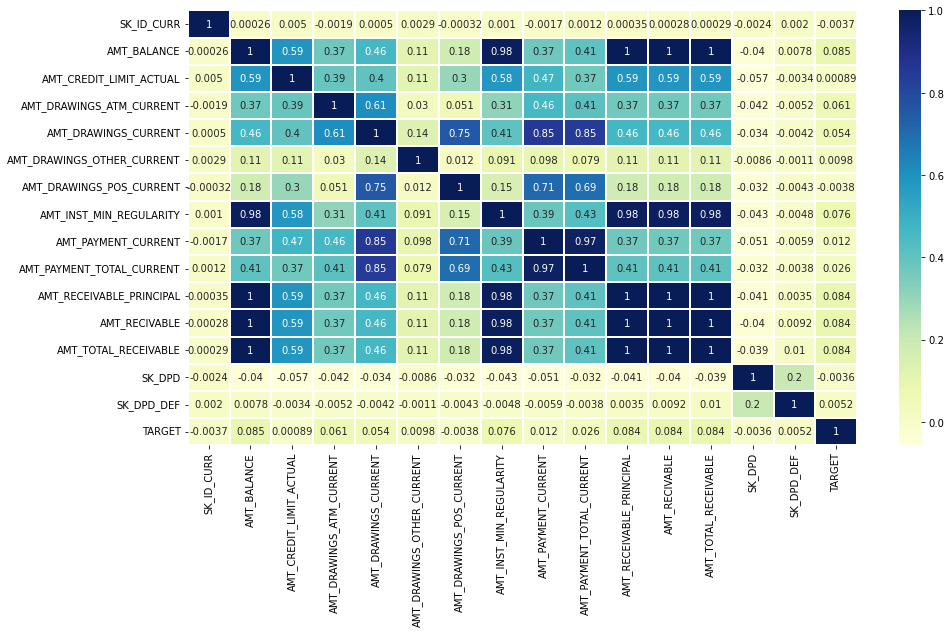

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df_to_corr.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr , annot=True, linewidths=.2, cmap="YlGnBu");

In [100]:
selected_columns= ['SK_ID_CURR','AMT_BALANCE','AMT_PAYMENT_CURRENT','SK_DPD','SK_DPD_DEF']

In [101]:
df_grouped= df_grouped[selected_columns]

In [102]:
credit_card_balance_grouped = df_grouped

In [103]:
gc.enable()
del credit_card_balance,df_grouped
gc.collect()

22141

In [104]:
credit_card_balance_grouped

,SK_ID_CURR,AMT_BALANCE,AMT_PAYMENT_CURRENT,SK_DPD,SK_DPD_DEF
0,100006,0.00,NaN,0.00,0.00
1,100011,0.00,563.35,0.00,0.00
2,100013,0.00,274.32,0.00,0.00
3,100021,0.00,NaN,0.00,0.00
4,100023,0.00,NaN,0.00,0.00
...,...,...,...,...,...
103553,456244,0.00,89.99,0.00,0.00
103554,456246,"13,136.73","18,778.28",0.00,0.00
103555,456247,0.00,520.60,0.00,0.00
103556,456248,0.00,NaN,0.00,0.00


## installments_payments

In [105]:
installments_payments = pd.read_csv(path_data+"/installments_payments.csv")
installments_payments = reduce_mem_usage(installments_payments)

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


In [106]:
installments_payments.shape

(13605401, 8)

In [107]:
installments_payments.drop(['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','SK_ID_PREV'],axis=1,inplace=True)

In [108]:
installments_payments

,SK_ID_CURR,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,161674,"-1,180.00","-1,187.00","6,948.36","6,948.36"
1,151639,"-2,156.00","-2,156.00","1,716.53","1,716.53"
2,193053,-63.00,-63.00,"25,425.00","25,425.00"
3,199697,"-2,418.00","-2,426.00","24,350.13","24,350.13"
4,167756,"-1,383.00","-1,366.00","2,165.04","2,160.58"
...,...,...,...,...,...
13605396,428057,"-1,624.00",NaN,67.50,NaN
13605397,414406,"-1,539.00",NaN,67.50,NaN
13605398,402199,-7.00,NaN,"43,737.43",NaN
13605399,409297,"-1,986.00",NaN,67.50,NaN


In [109]:
installments_payments = installments_payments[installments_payments['DAYS_INSTALMENT']>2*-365]

In [110]:
installments_payments['DAYS_INSTALMENT_delay'] = installments_payments['DAYS_ENTRY_PAYMENT']-installments_payments['DAYS_INSTALMENT']

In [111]:
installments_payments['AMT_INSTALMENT_delta'] = installments_payments['AMT_PAYMENT']-installments_payments['AMT_INSTALMENT']

In [112]:
installments_payments.drop(['DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT','AMT_PAYMENT','AMT_INSTALMENT'],axis=1,inplace=True)

In [113]:
installments_payments

,SK_ID_CURR,DAYS_INSTALMENT_delay,AMT_INSTALMENT_delta
2,193053,0.00,0.00
6,184693,-3.00,0.00
8,112102,0.00,0.00
9,109741,-39.00,0.00
16,170192,-3.00,0.00
...,...,...,...
13605390,450349,NaN,NaN
13605391,418486,NaN,NaN
13605392,434321,NaN,NaN
13605398,402199,NaN,NaN


In [114]:
installments_payments_grouped = installments_payments.groupby(['SK_ID_CURR']).agg({'DAYS_INSTALMENT_delay':'mean','AMT_INSTALMENT_delta':'mean'})

In [115]:
installments_payments_grouped.reset_index(inplace=True)

In [116]:
installments_payments_grouped

,SK_ID_CURR,DAYS_INSTALMENT_delay,AMT_INSTALMENT_delta
0,100002,-20.42,0.00
1,100003,-7.00,0.00
2,100004,-3.00,0.00
3,100005,-23.56,0.00
4,100006,-19.38,0.00
...,...,...,...
293763,456248,-8.96,0.00
293764,456250,-7.43,-219.41
293765,456251,-36.28,0.00
293766,456254,-19.00,0.00


In [117]:
gc.enable()
del installments_payments
gc.collect()

317

## previous_application 

In [118]:
previous_application = pd.read_csv(path_data+"/previous_application.csv")
previous_application = reduce_mem_usage(previous_application)

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%


In [119]:
df_final.columns[df_final.columns.isin(previous_application.columns)]

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'NAME_TYPE_SUITE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'],
      dtype='object')

In [120]:
previous_application.shape

(1670214, 37)

In [121]:
previous_application_drop_list = ['SK_ID_PREV','AMT_APPLICATION', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_PAYMENT_TYPE', 'NAME_CONTRACT_TYPE',
       'NAME_TYPE_SUITE', 
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
        'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'NFLAG_INSURED_ON_APPROVAL']

In [122]:
previous_application.drop(previous_application_drop_list,axis=1,inplace=True)

In [123]:
previous_application.shape

(1670214, 12)

In [124]:
previous_application.head(3)

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_DOWN_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,CODE_REJECT_REASON,NAME_CLIENT_TYPE,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_LAST_DUE,DAYS_TERMINATION
0,271877,"1,730.43","17,145.00",0.00,Approved,-73,XAP,Repeater,12.00,"365,243.00",-42.00,-37.00
1,108129,"25,188.62","679,671.00",NaN,Approved,-164,XAP,Repeater,36.00,"365,243.00","365,243.00","365,243.00"
2,122040,"15,060.74","136,444.50",NaN,Approved,-301,XAP,Repeater,12.00,"365,243.00","365,243.00","365,243.00"


In [125]:
previous_application[previous_application['SK_ID_CURR']==122040]

,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_DOWN_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,CODE_REJECT_REASON,NAME_CLIENT_TYPE,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_LAST_DUE,DAYS_TERMINATION
2,122040,"15,060.74","136,444.50",NaN,Approved,-301,XAP,Repeater,12.00,"365,243.00","365,243.00","365,243.00"
86475,122040,"6,300.00","90,000.00","9,571.50",Approved,-2405,XAP,Repeater,0.00,"-2,405.00","-1,847.00","365,243.00"
561217,122040,"7,508.61","64,341.00",0.00,Approved,-2576,XAP,Repeater,12.00,"365,243.00","-2,425.00","-2,417.00"
1536362,122040,NaN,0.00,NaN,Canceled,-301,XAP,Repeater,NaN,NaN,NaN,NaN


In [126]:
previous_application.columns

Index(['SK_ID_CURR', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'CODE_REJECT_REASON',
       'NAME_CLIENT_TYPE', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION'],
      dtype='object')

In [127]:
previous_application_num_col =  ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT','DAYS_DECISION','CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION']
previous_application_cat_col = ['NAME_CONTRACT_STATUS','CODE_REJECT_REASON','NAME_CLIENT_TYPE']


In [128]:
l ={}
for c in previous_application_num_col:
    l.update({c: 'mean'})

for c in previous_application_cat_col:
    l.update({c: lambda x:x.value_counts().index[0]})

In [129]:
previous_application_grouped = previous_application.groupby(['SK_ID_CURR']).agg(l)

In [130]:
previous_application_grouped.reset_index(inplace=True)

In [131]:
gc.enable()
del previous_application
gc.collect()

0

## POS_CASH_balance.csv

In [132]:
POS_CASH_balance = pd.read_csv(path_data+"/POS_CASH_balance.csv")
POS_CASH_balance = reduce_mem_usage(POS_CASH_balance)

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%


In [133]:
POS_CASH_balance.shape

(10001358, 8)

In [134]:
POS_CASH_balance = POS_CASH_balance[POS_CASH_balance['MONTHS_BALANCE']>-25]

In [135]:
POS_CASH_balance.shape

(4570126, 8)

In [136]:
POS_CASH_balance.drop(['CNT_INSTALMENT','SK_DPD_DEF','NAME_CONTRACT_STATUS','MONTHS_BALANCE','SK_ID_PREV'],axis=1,inplace=True)

In [139]:
POS_CASH_balance.shape

(4570126, 3)

In [140]:
POS_CASH_balance_grouped = POS_CASH_balance.groupby(['SK_ID_CURR']).agg({'CNT_INSTALMENT_FUTURE':'mean','SK_DPD':'mean'})

In [141]:
POS_CASH_balance_grouped.reset_index(inplace=True)

In [142]:
POS_CASH_balance_grouped.shape

(286498, 3)

In [143]:
gc.enable()
del POS_CASH_balance
gc.collect()

0

## Merge (data final)

In [144]:
df_final = df_final.merge(bureau_grouped, on = 'SK_ID_CURR', how = 'left')

In [145]:
df_final = df_final.merge(credit_card_balance_grouped, on = 'SK_ID_CURR', how = 'left')

In [146]:
df_final = df_final.merge(installments_payments_grouped, on = 'SK_ID_CURR', how = 'left')

In [147]:
df_final = df_final.merge(previous_application_grouped, on = 'SK_ID_CURR', how = 'left')

In [148]:
df_final = df_final.merge(POS_CASH_balance_grouped, on = 'SK_ID_CURR', how = 'left')

In [149]:
df_final.shape

(307511, 48)

In [150]:
df_final.select_dtypes(exclude= np.number).columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'CREDIT_ACTIVE',
       'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE'],
      dtype='object')

In [151]:
for c in (df_final.select_dtypes(exclude= np.number).columns):
    print (df_final[c].unique())
    

['Cash loans', 'Revolving loans']
Categories (2, object): ['Cash loans', 'Revolving loans']
['M', 'F', 'XNA']
Categories (3, object): ['F', 'M', 'XNA']
['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A', NaN, 'Other_B', 'Group of people']
Categories (7, object): ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied']
['working', 'not_working']
Categories (2, object): ['not_working', 'working']
['low_educ', 'high_educ']
Categories (2, object): ['high_educ', 'low_educ']
['not_married', 'married', 'other']
Categories (3, object): ['married', 'not_married', 'other']
['other', NaN, 'Low-skill Laborers']
Categories (2, object): ['other', 'Low-skill Laborers']
['WEDNESDAY', 'MONDAY', 'THURSDAY', 'SUNDAY', 'SATURDAY', 'FRIDAY', 'TUESDAY']
Categories (7, object): ['FRIDAY', 'MONDAY', 'SATURDAY', 'SUNDAY', 'THURSDAY', 'TUESDAY', 'WEDNESDAY']
['Closed' nan 'Active' 'Sold']
['Approved' nan 'Refused' 'Canceled' 'Unused offer']
['XAP' nan

In [152]:
df_final.drop(['WEEKDAY_APPR_PROCESS_START'] ,axis = 1, inplace = True)

In [153]:
df_final.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_WORK_CITY,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_ACTIVE,DAYS_CREDIT,AMT_CREDIT_SUM,AMT_BALANCE,AMT_PAYMENT_CURRENT,SK_DPD_x,SK_DPD_DEF,DAYS_INSTALMENT_delay,AMT_INSTALMENT_delta,AMT_ANNUITY,AMT_CREDIT_y,AMT_DOWN_PAYMENT,DAYS_DECISION,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_LAST_DUE,DAYS_TERMINATION,NAME_CONTRACT_STATUS,CODE_REJECT_REASON,NAME_CLIENT_TYPE,CNT_INSTALMENT_FUTURE,SK_DPD_y
0,100002,1,Cash loans,M,0,"202,500.00","406,597.50",Unaccompanied,working,low_educ,not_married,0.02,-9461,-637,NaN,other,1.00,2,2,10,0,0.01,2.00,1,1.00,Closed,-874.00,"108,131.95",NaN,NaN,NaN,NaN,-20.42,0.00,"9,251.78","179,055.00",0.00,-606.00,24.00,"365,243.00",-25.00,-17.00,Approved,XAP,New,15.00,0.00
1,100003,0,Cash loans,F,0,"270,000.00","1,293,502.50",Family,working,high_educ,married,0.00,-16765,-1188,NaN,other,2.00,1,1,11,0,0.07,0.00,1,0.00,Closed,"-1,400.75","254,350.12",NaN,NaN,NaN,NaN,-7.00,0.00,"56,553.99","484,191.00","3,442.50","-1,305.00",10.00,"365,243.00","-1,054.33","-1,047.33",Approved,XAP,Refreshed,4.91,0.00
2,100004,0,Revolving loans,M,0,"67,500.00","135,000.00",Unaccompanied,working,low_educ,not_married,0.01,-19046,-225,26.00,other,1.00,2,2,9,0,NaN,0.00,0,0.00,Closed,-867.00,"94,518.90",NaN,NaN,NaN,NaN,-3.00,0.00,"5,357.25","20,106.00","4,860.00",-815.00,4.00,"365,243.00",-724.00,-714.00,Approved,XAP,New,0.00,0.00
3,100006,0,Cash loans,F,0,"135,000.00","312,682.50",Unaccompanied,working,low_educ,married,0.01,-19005,-3039,NaN,other,2.00,2,2,17,0,NaN,0.00,1,NaN,NaN,NaN,NaN,0.00,NaN,0.00,0.00,-19.38,0.00,"23,651.18","291,695.50","34,840.17",-272.44,23.00,"365,243.00","182,477.50","182,481.75",Approved,XAP,Repeater,8.65,0.00
4,100007,0,Cash loans,M,0,"121,500.00","513,000.00",Unaccompanied,working,low_educ,not_married,0.03,-19932,-3038,NaN,other,1.00,2,2,11,1,NaN,0.00,0,0.00,Closed,"-1,149.00","146,250.00",NaN,NaN,NaN,NaN,-6.32,0.00,"12,278.80","166,638.75","3,390.75","-1,222.83",20.67,"365,243.00","72,136.20","72,143.80",Approved,XAP,Repeater,11.66,0.00


In [154]:
df_final.to_csv('df_final.csv')

### Conclusion

On a mergé tous les fichiers ensembles en minimisant le nombre de colonnes et de lignes en se basant sur l'analyse exploratoire.
Le dataframe finalement retenu est de taille (307511, 48).